# Big Data Management and Analysis in Physics Research - Progetto

## Esercizio serie storica - Consegna

Questo secondo esercizio richiede di effettuare un'analisi di dati di serie storica.

Leggendo il dataset `data/globaltemperatures.csv`, caricare i dati della media della temperatura nei diversi mesi dell'anno dal 1750. Plottare la serie dati, analizarne le caratteristiche (tendenza e stagionalità) e provare a fare una regressione lineare del trend (per valutarne la tendenza). Per fare regressione lineare di una timeseries è conveniente trasformare l'indice (l'asse X) in un numero che indica il numero di periodi passati dal momento inziale.

Infine provare a usare la serie storica per produrre le temperature dei successivi 10 anni.

## Import libraries

In [1]:
import datetime

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

## Import data

In [2]:
df = pd.read_csv("data/globaltemperatures.csv", parse_dates=["dt"], index_col="dt")
df["t"] = np.arange(df.shape[0])
df["date"] = df.index
df.head()

,LandAverageTemperature,LandAverageTemperatureUncertainty,t,date
dt,,,,
1750-01-01,3.034,3.574,0,1750-01-01
1750-02-01,3.083,3.702,1,1750-02-01
1750-03-01,5.626,3.076,2,1750-03-01
1750-04-01,8.490,2.451,3,1750-04-01
1750-05-01,11.573,2.072,4,1750-05-01


## Plot Time Series

In [3]:
df.tail()

,LandAverageTemperature,LandAverageTemperatureUncertainty,t,date
dt,,,,
2015-08-01,14.755,0.072,3187,2015-08-01
2015-09-01,12.999,0.079,3188,2015-09-01
2015-10-01,10.801,0.102,3189,2015-10-01
2015-11-01,7.433,0.119,3190,2015-11-01
2015-12-01,5.518,0.100,3191,2015-12-01


Let us visualize the monthly time series of temperatures and its annual averages:

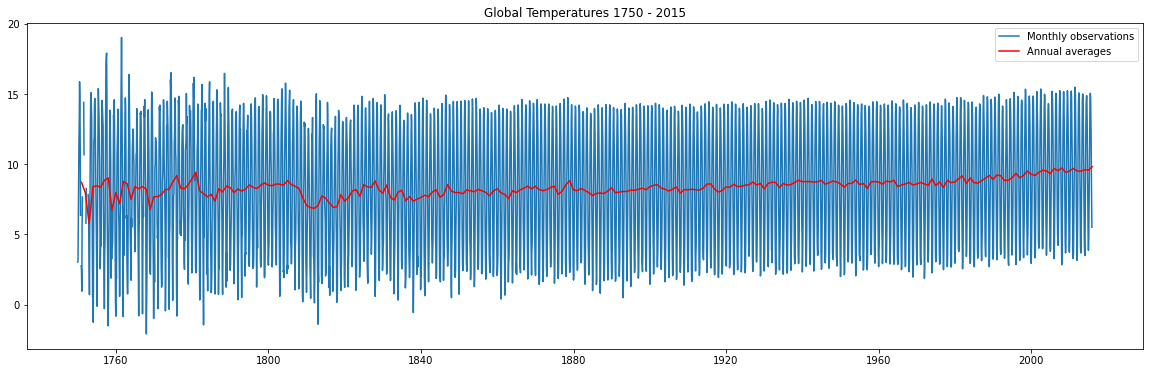

In [4]:
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(df.LandAverageTemperature, label = "Monthly observations")
plt.plot(df.LandAverageTemperature.resample("Y").mean(), color="red", label = "Annual averages")
plt.title("Global Temperatures 1750 - 2015")
plt.legend()
plt.show()

## Fill Missing Values

Let's make a copy of the `LandAverageTemperature` column, in which we will fill the missing values:

In [5]:
df["tsFilled"] = df.LandAverageTemperature

There are only 12 missing values:

In [6]:
np.sum(df.tsFilled.isna())

12

Let's try linear interpolation for filling missing values:

In [7]:
df["tsFilled"] = df.tsFilled.interpolate()

No more missing values:

In [8]:
np.sum(df.tsFilled.isna())

0

All the missing values are between 1750 and 1752:

In [9]:
df[df.LandAverageTemperature.isna()].date

dt
1750-11-01   1750-11-01
1751-05-01   1751-05-01
1751-07-01   1751-07-01
1751-10-01   1751-10-01
1751-11-01   1751-11-01
1751-12-01   1751-12-01
1752-02-01   1752-02-01
1752-05-01   1752-05-01
1752-06-01   1752-06-01
1752-07-01   1752-07-01
1752-08-01   1752-08-01
1752-09-01   1752-09-01
Name: date, dtype: datetime64[ns]

Let's visualize the interpolated values:

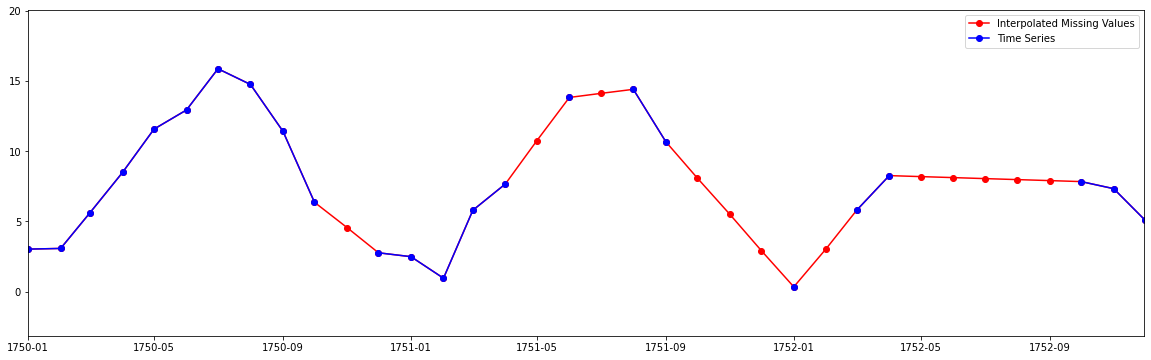

In [10]:
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(df.index, df.tsFilled, color="red", marker="o", label="Interpolated Missing Values")
plt.plot(df.index, df.LandAverageTemperature, color="blue", marker="o", label="Time Series")
plt.legend()
ax.set_xlim([datetime.date(1750, 1, 1), datetime.date(1752, 11, 30)]) 
plt.show()

The linear interpolation strategy does not seem adequate for this time series; the year 1752 in particular is flat, as the linear interpolation does not capture the seasonality.

Instead, let us compute the monthly temperature means (for 1750-1759).

In [11]:
df["month"] = df.date.dt.month
means = df.loc["1750":"1759"].groupby("month")["LandAverageTemperature"].mean()
means

month
1      1.767900
2      1.962444
3      4.694600
4      8.505100
5     11.960375
6     14.381111
7     14.740875
8     14.236222
9     12.052000
10     7.408333
11     5.535875
12     2.472222
Name: LandAverageTemperature, dtype: float64

Let's extend the array of means so that it has the same length as the df

In [12]:
means = np.array(list(means)*(int(df.shape[0]/12)))

As before, in the column `tsFilled` we create a copy of the original time series (including the missing values).

In [13]:
df["tsFilled"] = df.LandAverageTemperature
np.sum(df.tsFilled.isna())

12

Let us replace the missing values in this column with the monthly averages:

In [14]:
idx = df.LandAverageTemperature.isna()
df.loc[idx, "tsFilled"] = means[idx]

In [15]:
np.sum(df.tsFilled.isna())

0

Let us visualize how the missing values have been replaced by the monthly means:

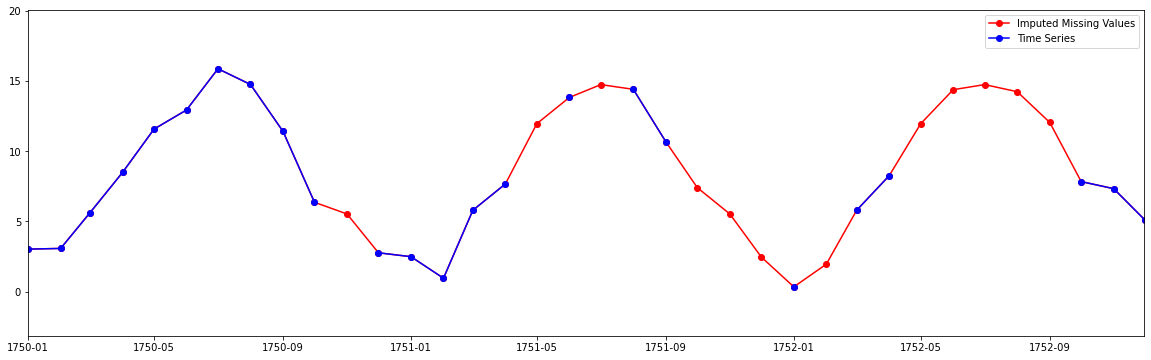

In [16]:
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(df.index, df.tsFilled, color="red", marker="o", label="Imputed Missing Values")
plt.plot(df.index, df.LandAverageTemperature, color="blue", marker="o", label="Time Series")
plt.legend()
ax.set_xlim([datetime.date(1750, 1, 1), datetime.date(1752, 11, 30)]) 
plt.show()

This strategy for missing values seems to make more sense.

## Trend and Seasonality

Let us visualize the trend and seasonality of the time series, using the function `seasonal_decompose` from `statsmodels`.

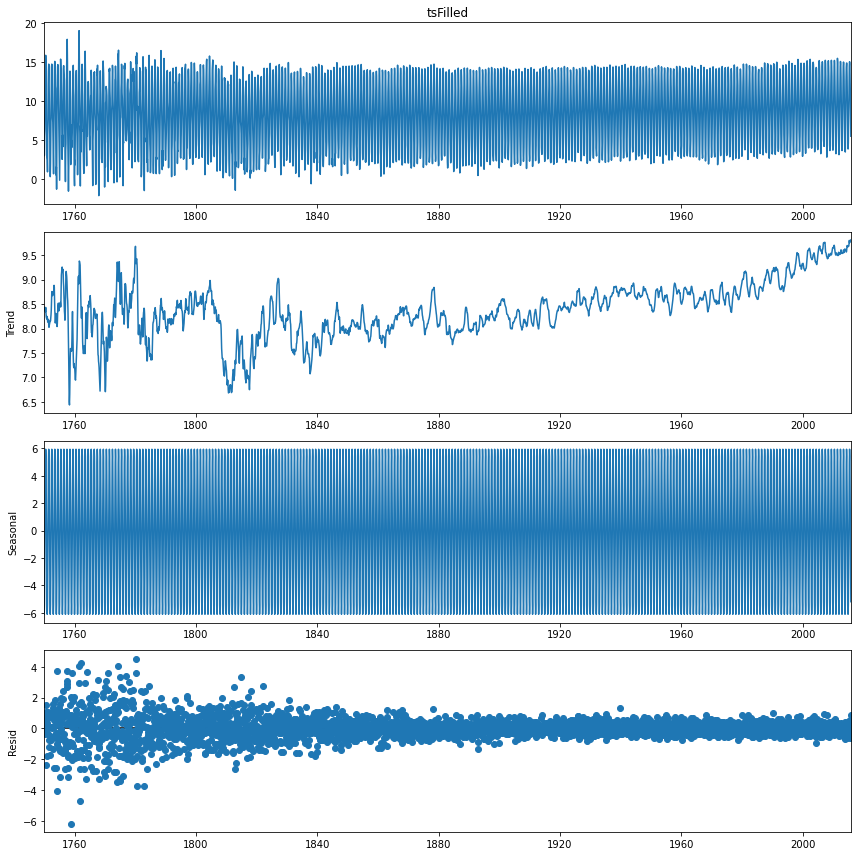

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Additive Decomposition 
result_add = seasonal_decompose(df['tsFilled'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (12, 12)})
result_add.plot()
plt.show()

We note that the temperature trend is rising.

Better look at the seasonality:

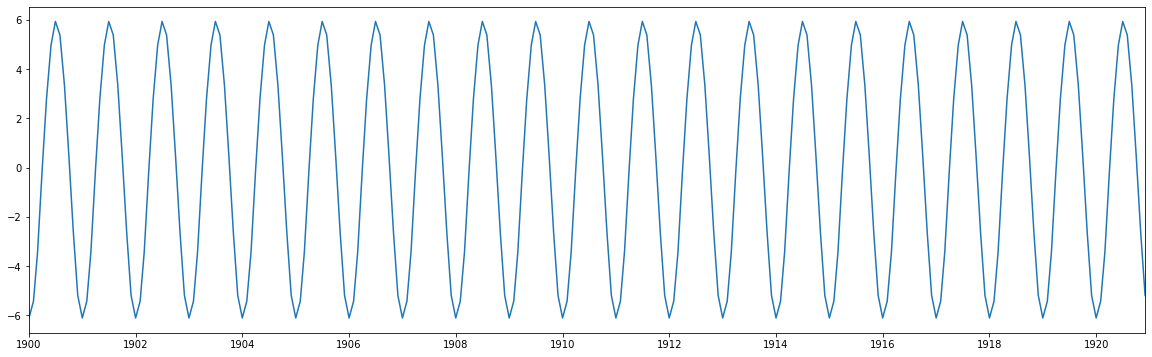

In [18]:
fig, ax= plt.subplots(figsize=(20,6))
plt.plot(df.date, result_add.seasonal)
ax.set_xlim([datetime.date(1900, 1, 1), datetime.date(1920, 11, 30)]) 
plt.show()

## Linear Regression Trend

Now we estimate a trend with a linear regression.

In [19]:
from numpy.polynomial.polynomial import polyfit

In [20]:
y = df.tsFilled.values

`x` is the "time" variable:

In [21]:
# x = np.arange(1, df.shape[0]+1)
x = np.arange(df.shape[0]) + 1
x[:5]

array([1, 2, 3, 4, 5])

We use `polyfit` from `numpy` to find the intercept and the slope coefficient.

In [22]:
a, b = polyfit(x, y, 1)

Plot the linear trend:

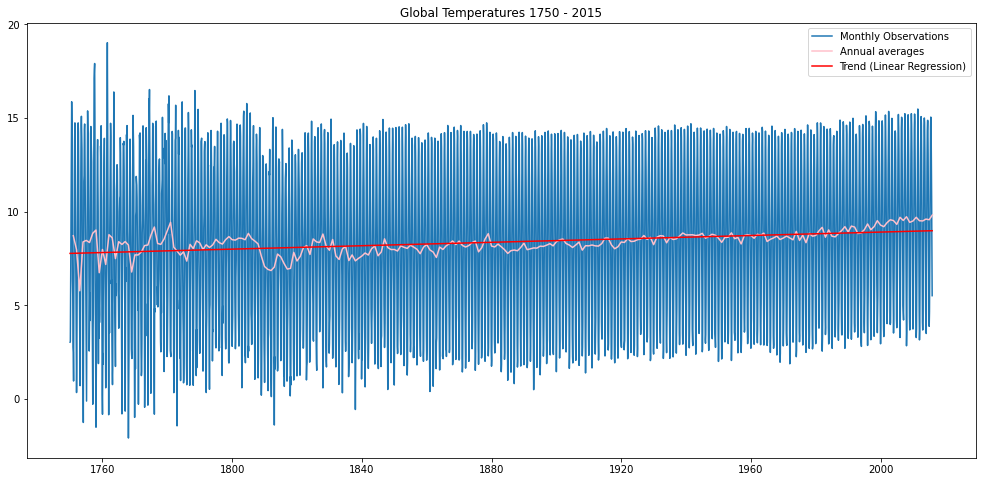

In [23]:
plt.figure(figsize=(17,8))
plt.plot(df.date, y, label="Monthly Observations")
plt.plot(df.LandAverageTemperature.resample("Y").mean(), color="pink", label = "Annual averages")
plt.plot(df.date, a + b * x, color="red", label="Trend (Linear Regression)")
plt.title("Global Temperatures 1750 - 2015")
plt.legend()
plt.show()

We can use statsmodels to perform a $t$ test on the significance of the trend.

In [24]:
import statsmodels.api as sm

We add a constant to `x` for the intercept (needed by statsmodels):

In [25]:
X = sm.add_constant(x)
print(X[:5])

[[1. 1.]
 [1. 2.]
 [1. 3.]
 [1. 4.]
 [1. 5.]]


We run an ordinary least squares regression of y on X:

In [26]:
model = sm.OLS(y, X)
OLS_results = model.fit()
OLS_trend = OLS_results.params[1]*12 # x12 for yearly trend2
OLS_p = OLS_results.pvalues[1]

In [27]:
print(f"H0: Trend = 0.\nOLS Trend: {OLS_trend:.5f} °C / year\np value: {OLS_p}")

H0: Trend = 0.
OLS Trend: 0.00455 °C / year
p value: 6.4847583193979795e-06


The p value is very small, so the trend is significant.

The dataset also provides the uncertainty of the observations:

In [28]:
df.LandAverageTemperatureUncertainty

dt
1750-01-01    3.574
1750-02-01    3.702
1750-03-01    3.076
1750-04-01    2.451
1750-05-01    2.072
              ...  
2015-08-01    0.072
2015-09-01    0.079
2015-10-01    0.102
2015-11-01    0.119
2015-12-01    0.100
Name: LandAverageTemperatureUncertainty, Length: 3192, dtype: float64

We can use these to perform a linear regression using Weighted Least Squares. (Assuming that the `LandAverageTemperatureUncertainty` values are standard deviations of the error and following https://www.statsmodels.org/devel/examples/notebooks/generated/wls.html).

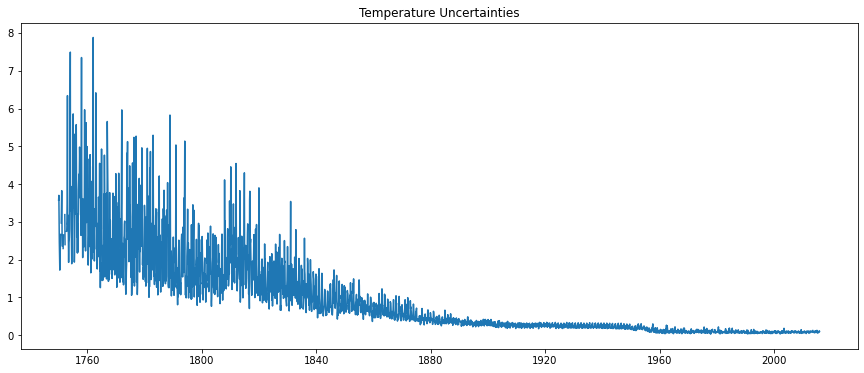

In [29]:
plt.figure(figsize=(15,6))
plt.plot(df.index, df.LandAverageTemperatureUncertainty)
plt.title("Temperature Uncertainties")
plt.show()

Since the uncertainty is much greater between 1760 and around 1900, WLS will assign more weight to observations after (around) 1900.

In [30]:
# following https://www.statsmodels.org/devel/examples/notebooks/generated/wls.html
weights = 1./(df.LandAverageTemperatureUncertainty**2)

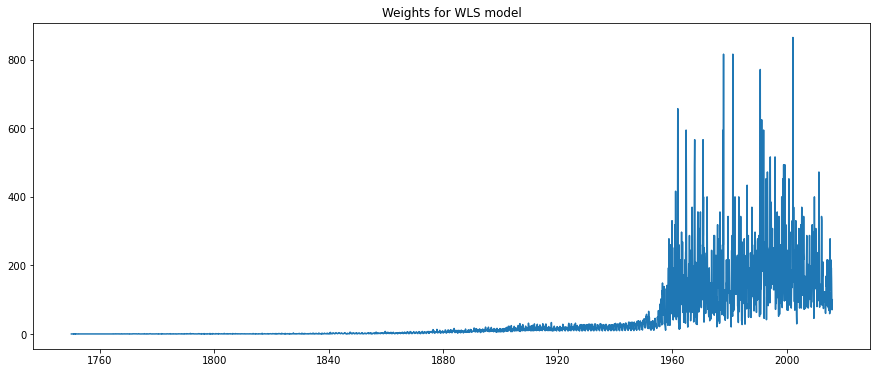

In [31]:
plt.figure(figsize=(15,6))
plt.plot(df.index, weights)
plt.title("Weights for WLS model")
plt.show()

Similarly to the temperature column, not all data is available for the uncertainty column.

In [32]:
np.sum(np.isnan(df.LandAverageTemperatureUncertainty))

12

We discard the missing observations instead of imputing them.

In [33]:
mask = ~np.isnan(weights)
model = sm.WLS(y[mask], X[mask], weights = weights[mask])
WLS_results = model.fit()
WLS_trend = WLS_results.params[1]*12 # x12 for yearly trend
WLS_p = WLS_results.pvalues[1]

In [34]:
print(f"H0: Trend = 0.\nWLS Trend: {WLS_trend:.5f} °C / year \np value: {WLS_p}")

H0: Trend = 0.
WLS Trend: 0.01082 °C / year 
p value: 6.089333384079943e-06


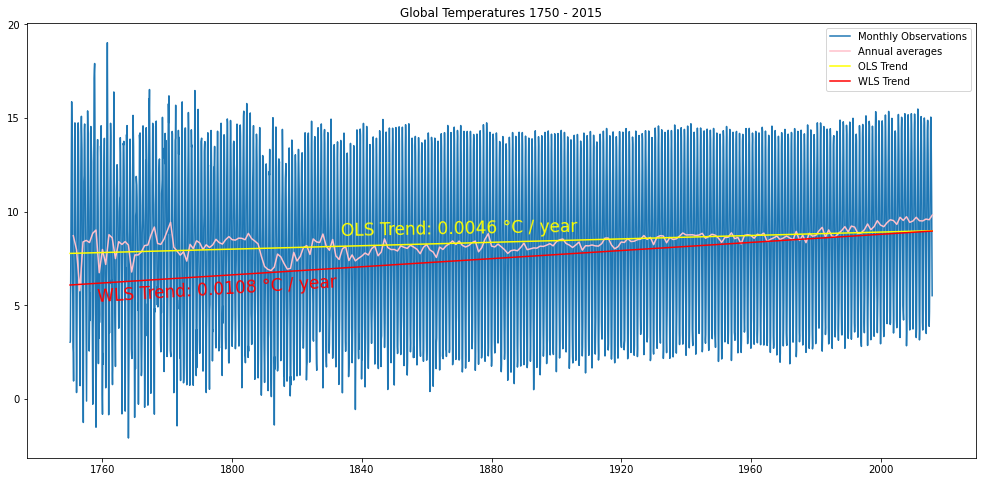

In [35]:
plt.figure(figsize=(17,8))
plt.plot(df.date, y, label="Monthly Observations")
plt.plot(df.LandAverageTemperature.resample("Y").mean(), color="pink", label = "Annual averages")
col1 = "yellow"
col2 = "red"
fs=17
plt.title("Global Temperatures 1750 - 2015")
plt.plot(df.index, OLS_results.predict(X), color = col1, label = "OLS Trend")
plt.plot(df.index, WLS_results.predict(X), color = col2, label = "WLS Trend")
plt.text(df.index[1000], 8.7, f"OLS Trend: {OLS_trend:.4f} °C / year", fontsize=fs, color=col1, rotation=1)
plt.text(df.index[100], 5.2, f"WLS Trend: {WLS_trend:.4f} °C / year", fontsize=fs, color=col2, rotation=3.5)
plt.legend()
plt.show()

In [36]:
print(f"OLS Trend: {OLS_trend} °C / year\nWLS Trend: {WLS_trend} °C / year")

OLS Trend: 0.004550411930901321 °C / year
WLS Trend: 0.010822785637047153 °C / year


According to the WLS model, the temperature is rising at a rate of around 0.11 °C per decade (since 1750).

According to the NASA Earth Observatory (https://earthobservatory.nasa.gov/world-of-change/global-temperatures), the global temperature has increased by a rate of roughly 0.15-0.20 °C per decade since 1880.

## ACF/PACF

Let us plot the ACF/PACF functions of the data.

In [37]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

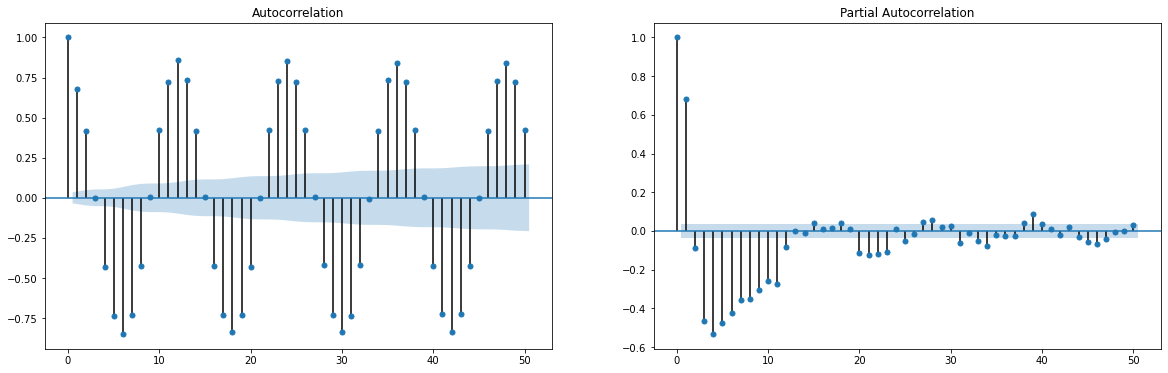

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(20,6))
plot_acf(np.diff(y), lags=50, ax=axes[0])
plot_pacf(np.diff(y), lags=50, ax=axes[1])
plt.show()

We can note a strong annual seasonality.

## Forecast

Finally, let us forecast the temperature for the next 10 years with an Arima model.

In [39]:
import pmdarima as pm

We will use the `auto_arima` function from `pmdarima` to find a suitable arima model. The model will be chosen on a train set consisting of all the data except the last 10 years. We will compare the forecasts for these 10 years with the real data. Afterwards, we will fit the Arima model chosen by `pmdarima` on the whole data, and forecast the next 10 years.

In [40]:
lookback=12*10 # 120 months
future = df.iloc[-lookback:]["tsFilled"]
past = df.iloc[:-lookback]["tsFilled"]

In [41]:
smodel = pm.auto_arima(past, start_p=1, start_q=1,
                       test='adf',
                       max_p=3, max_q=3, m=12,
                       start_P=0, seasonal=True,
                       d=None, D=1, trace=True,
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,1,1,12) [intercept=True]; AIC=7137.011, BIC=7167.142, Time=6.212 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=True]; AIC=9094.049, BIC=9106.101, Time=0.114 seconds
Fit ARIMA(1,0,0)x(1,1,0,12) [intercept=True]; AIC=8035.548, BIC=8059.653, Time=1.641 seconds
Fit ARIMA(0,0,1)x(0,1,1,12) [intercept=True]; AIC=7242.867, BIC=7266.972, Time=3.616 seconds
Near non-invertible roots for order (0, 0, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.994)
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=False]; AIC=9092.113, BIC=9098.139, Time=0.131 seconds
Fit ARIMA(1,0,1)x(0,1,0,12) [intercept=True]; AIC=8812.783, BIC=8836.888, Time=0.814 seconds
Fit ARIMA(1,0,1)x(1,1,1,12) [intercept=True]; AIC=7118.799, BIC=7154.956, Time=10.453 seconds
Near non-invertible roots for order (1, 0, 1)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit c

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 3072
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -3553.399
Date:                            Sun, 06 Sep 2020   AIC                           7118.799
Time:                                    22:01:12   BIC                           7154.956
Sample:                                         0   HQIC                          7131.791
                                           - 3072                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0016      0.001      2.279      0.023       0.000       0.003
ar.L1          0.5441      0.025     21.753      0.000       0.495       0.593
ma.L1         -0.2151      0.029     -7.486      0.000      -0.271      -0.159
ar.S.L12       0.0860      0.011      7.980      0.000       0.065       0.107
ma.S.L12      -0.9586      0.007   -144.828      0.000      -0.972      -0.946
sigma2         0.5918      0.008     77.136      0.000       0.577       0.607
===================================================================================
Ljung-Box (Q):                      165.42   Jarque-Bera (JB):              6030.09
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.07   Skew:                             0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
smodel

ARIMA(order=(1, 0, 1), seasonal_order=(1, 1, 1, 12), suppress_warnings=True)

`pmdarima` has chosen an $\mathrm{ARIMA}(101)(111)_{12}$ model.

Let us plot the whole time series and the values predicted for the period 2006-2015.

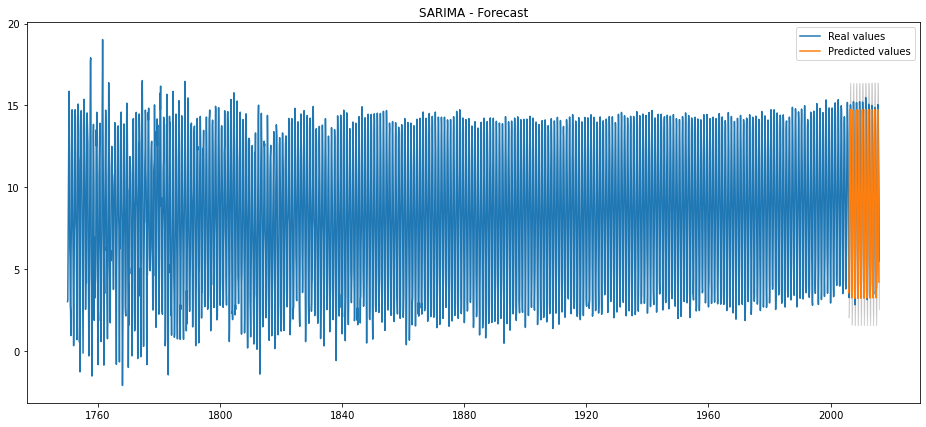

In [43]:
# Forecast
n_periods = 12*10
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(past.index[-1], periods=n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(16, 7))

plt.plot(df.tsFilled, label = "Real values")
# plt.plot(future, label="Real values")

plt.plot(fitted_series, label="Predicted values")
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.legend()
plt.title("SARIMA - Forecast")
plt.show()

To get a better idea, let us plot only the real vs. predicted values.

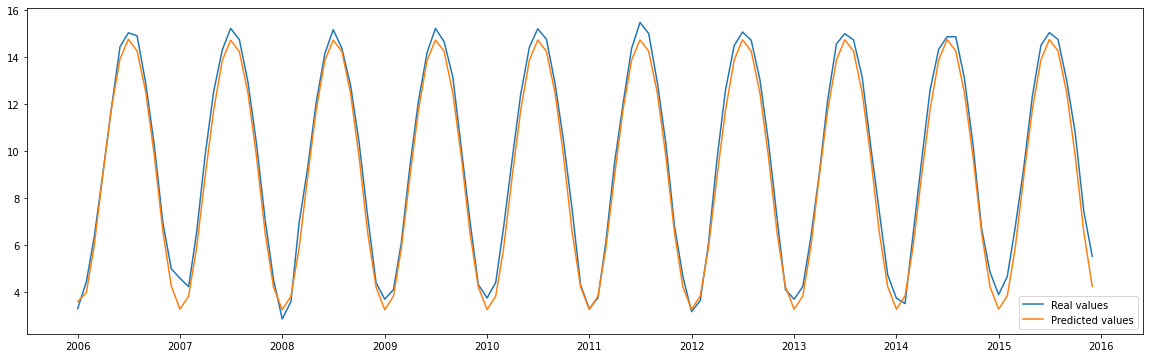

In [44]:
plt.figure(figsize=(20, 6))
plt.plot(future, label="Real values")
plt.plot(future.index, fitted, label="Predicted values")
plt.legend()
plt.show()

The predictions seem very accurate.

Now let us fit the Arima model chosen by `pmdarima` on the whole data, and predict the next 10 years.

In [45]:
ar = pm.arima.ARIMA(order=(1,0,1), seasonal_order=(1,1,1,12))

In [46]:
fit = ar.fit(df["tsFilled"])

In [47]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 3192
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -3644.128
Date:                            Sun, 06 Sep 2020   AIC                           7300.257
Time:                                    22:01:22   BIC                           7336.645
Sample:                                         0   HQIC                          7313.307
                                           - 3192                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0019      0.001      2.678      0.007       0.001       0.003
ar.L1          0.5495      0.024     22.918      0.000       0.503       0.596
ma.L1         -0.2192      0.028     -7.950      0.000      -0.273      -0.165
ar.S.L12       0.0834      0.010      7.955      0.000       0.063       0.104
ma.S.L12      -0.9548      0.006   -148.731      0.000      -0.967      -0.942
sigma2         0.5743      0.007     79.887      0.000       0.560       0.588
===================================================================================
Ljung-Box (Q):                      179.84   Jarque-Bera (JB):              6752.38
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.07   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
preds = fit.predict(n_periods=10*12)

In [49]:
df.tail()

,LandAverageTemperature,LandAverageTemperatureUncertainty,t,date,tsFilled,month
dt,,,,,,
2015-08-01,14.755,0.072,3187,2015-08-01,14.755,8
2015-09-01,12.999,0.079,3188,2015-09-01,12.999,9
2015-10-01,10.801,0.102,3189,2015-10-01,10.801,10
2015-11-01,7.433,0.119,3190,2015-11-01,7.433,11
2015-12-01,5.518,0.100,3191,2015-12-01,5.518,12


In [50]:
predsdf = pd.DataFrame({"preds": preds, "dt":pd.date_range(start = "2016", end="2026", freq="m")})
predsdf.head()

,preds,dt
0,3.884285,2016-01-31
1,4.248196,2016-02-29
2,6.285598,2016-03-31
3,9.246781,2016-04-30
4,12.043635,2016-05-31


Let us plot the data from 1900, followed by the predictions.

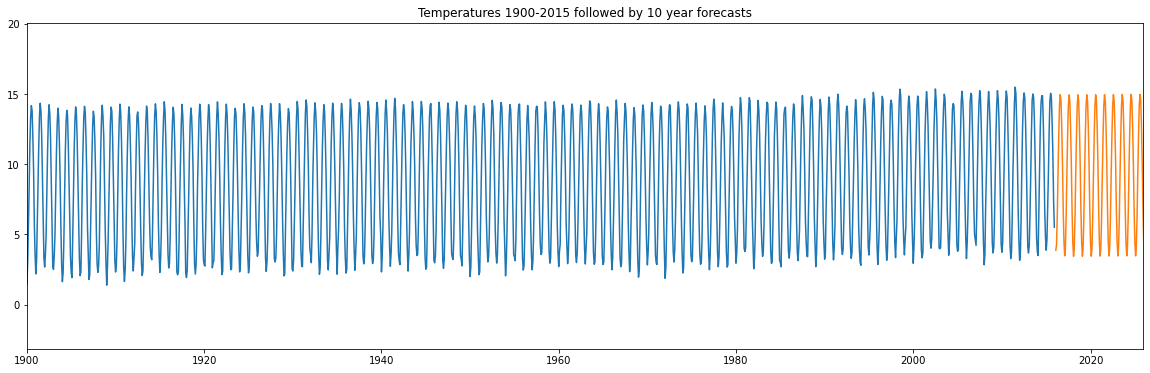

In [52]:
fig, ax= plt.subplots(figsize=(20,6))
plt.plot(df.date, df.tsFilled)
plt.plot(predsdf.dt, predsdf.preds)
ax.set_xlim([datetime.date(1900, 1, 1), datetime.date(2025, 11, 30)]) 
plt.title("Temperatures 1900-2015 followed by 10 year forecasts")
plt.show()